<a href="https://colab.research.google.com/github/Epic721/Understanding-Siri-NLP/blob/main/AK_UnderstandingSiri_N2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook 2

In this second notebook, I preprocessed the dataset for the ML models and implemented a pretrained BERT model.

## Sentence Level Classification

To elaborate, **BERT** stands for **B**idirectional **E**ncoder **R**epresentations from **T**ransformers, and is a novel model architecture that uses both the left and right *context* words in a sequence to generate context-based word embeddings.

I made use of existing Pytorch APIs for BERT that allowed me convert my voice command sequence data into the format that the BERT model expects, and then use pretrained BERT for the classification task.

Here is a surface-level diagram of BERT:


<img src="https://pytorch.org/tutorials/_images/bert.png" height="300">

Out of the many available pretrained BERT models, I used the cased BERT base (trained on the English text; 12 layers - 6 layers within the encoder and 6 layers within the decoder - and 12 attention heads).





In [ ]:
#Previously implemented code
%tensorflow_version 2.x
%pip install -q transformers

from urllib.request import urlretrieve
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Siri%20(Bert)%20Voice%20Commands/train'
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Siri%20(Bert)%20Voice%20Commands/valid'
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Siri%20(Bert)%20Voice%20Commands/test'
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Siri%20(Bert)%20Voice%20Commands/vocab.intent'
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Siri%20(Bert)%20Voice%20Commands/vocab.slot'

def parse_line(line):
    data, intent_label = line.split(" <=> ")
    items = data.split()
    words = [item.rsplit(":", 1)[0]for item in items]
    word_labels = [item.rsplit(":", 1)[1]for item in items]
    return {
        "intent_label": intent_label,
        "words": " ".join(words),
        "word_labels": " ".join(word_labels),
        "length": len(words),
    }


train_lines = Path("train").read_text().strip().splitlines()
valid_lines = Path("valid").read_text().strip().splitlines()
test_lines = Path("test").read_text().strip().splitlines()

df_train = pd.DataFrame([parse_line(line) for line in train_lines])
df_valid = pd.DataFrame([parse_line(line) for line in valid_lines])
df_test = pd.DataFrame([parse_line(line) for line in test_lines])

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 89.3 MB/s eta 0:00:00
train               100%[===================>]   1.71M  4.20MB/s    in 0.4s    
valid               100%[===================>]  96.30K   554KB/s    in 0.2s    
test                100%[===================>]  94.49K  --.-KB/s    in 0.09s   
vocab.intent        100%[===================>]      99  --.-KB/s    in 0s      
vocab.slot          100%[===================>]     994  --.-KB/s    in 0s      


As a reminder, `df_train`, `df_valid`, and `df_test` are the Pandas Dataframes that store the training, validation, and test datapoints.

### Tokenizing the Data

BERT expects input sequences to be broken down into individual *tokens*; a `[CLS]` token marks the beginning and a `[SEP]` marks the end of a given sequence (as seen in the red input sentences in the image above).

The `[CLS]` token is used by BERT for the pre-training task for sequence classification.

The `[SEP]` token is a separator for the pre-training task that classifies if a pair of sentences are consecutive in a corpus or not, i.e. next sentence prediction (NSP).

In [ ]:
# Imports the BERT tokenizer and utilizes the BERT base pretrained model
from transformers import BertTokenizer

model_name = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

As shown below, there are roughly 30,000 token that BERT knows.

In [ ]:
tokenizer.vocab_size

28996

As an example, this is how the BERT tokenizer works on a single training instance:

In [ ]:
# Prints the first training data sequence
first_sentence = df_train.iloc[0]["words"]
print(first_sentence)
print("This sentence contains {} words.".format(len(first_sentence.split(" "))))

Add Don and Sherri to my Meditate to Sounds of Nature playlist
This sentence contains 12 words.


In [ ]:
tokens = tokenizer.tokenize(first_sentence)
for t in tokens:
  print(t)
print("\nThis sentence turns into {} tokens.".format(len(tokens)))

Ad
##d
Don
and
She
##rri
to
my
Me
##dit
##ate
to
Sounds
of
Nature
play
##list

This sentence turns into 17 tokens.


My example demonstrates how BERT uses something called subword tokenization.

**Subword tokenization** may break some words into smaller units and does not always use a 1:1 mapping of words to tokens. Because of subword tokenization within BERT, the length of tokenized sentences is likely to be larger than the original number of words in the sentence.

### Encoding Tokens

In this model, each token is mapped to a unique integer id that facilitates lookup of the correct column in the input layer token embedding (seen in yellow below).

<img src="https://miro.medium.com/max/1496/1*fywysLzEbXxEqkPeIUWaJw.png" width="500">

In [ ]:
# Viewing the first 10 (token,id) pairs within BERT.
bert_vocab_items = list(tokenizer.vocab.items())
bert_vocab_items[:10]

[('[PAD]', 0),
 ('[unused1]', 1),
 ('[unused2]', 2),
 ('[unused3]', 3),
 ('[unused4]', 4),
 ('[unused5]', 5),
 ('[unused6]', 6),
 ('[unused7]', 7),
 ('[unused8]', 8),
 ('[unused9]', 9)]

In [ ]:
# More (token,id) examples within BERT's vocab.
bert_vocab_items[1100:1110]

[('－', 1100),
 ('／', 1101),
 ('：', 1102),
 ('the', 1103),
 ('of', 1104),
 ('and', 1105),
 ('to', 1106),
 ('in', 1107),
 ('was', 1108),
 ('The', 1109)]

In [ ]:
# Special tokens
bert_vocab_items[100:104]

[('[UNK]', 100), ('[CLS]', 101), ('[SEP]', 102), ('[MASK]', 103)]

As a clarification, the `[UNK]` token is used to replace tokens that BERT doesn't recognize. If there is no way to split a word into subtokens, the whole word becomes `[UNK]`.

`[CLS]` marks the beginning of a sentence, and `[SEP]` marks the end.

`[MASK]` is used by BERT in the pre-training task called MLM (Masked Language Model) where it learns to predict the original word if it's masked out in a sentence.

Now, I tested how the example training sequence can be encoded into the corresponding list of token embedding ids and decoded back into the original input tokens.

In [ ]:
# View the integer indexes for the token embeddings of the first sentence.
idxs = tokenizer.encode(first_sentence)
print(idxs)

[101, 24930, 1181, 1790, 1105, 1153, 14791, 1106, 1139, 2508, 17903, 2193, 1106, 10560, 1104, 7009, 1505, 7276, 102]


In [ ]:
# Decode the encoding, which should produce the original sequence.
tokenizer.decode(idxs)

'[CLS] Add Don and Sherri to my Meditate to Sounds of Nature playlist [SEP]'

### Padding Tokenized Sequences

**Transfer learning**, i.e. using *pretrained* BERT applied to the new dataset and sentiment classification task, requires that the sequences are **padded**, which means they all have the same length.


In the Training Data Analysis section of my 1st notebook, I created a histogram according to the lengths of training sequences. Now, I generated a histogram of the **tokenized** sequences:

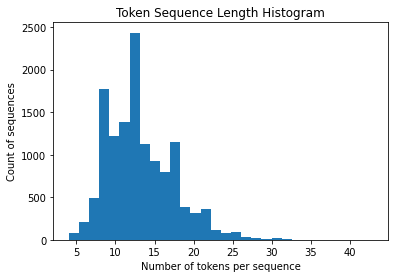

In [ ]:
train_sequence_lengths = [len(tokenizer.encode(text))
                          for text in df_train["words"]] #Using tokenizer.encode on every sequence within df_train
plt.hist(train_sequence_lengths, bins=30)


plt.xlabel("Number of tokens per sequence")
plt.ylabel("Count of sequences")
plt.title("Token Sequence Length Histogram")
plt.show()

In [ ]:
max_token_len = max(train_sequence_lengths)
print("Maximum tokenized sequence length: {} tokens per sequence".format(max_token_len))

Maximum tokenized sequence length: 43 tokens per sequence


As a refresher, the maximum of the original voice command lengths was 35 words per sequence.

The above histogram shows that after tokenization, 43 tokens is long enough to represent all the voice commands in the training set.

### Preprocessing Full Dataset

<img src="https://miro.medium.com/max/2152/1*vNGH3DTu83pZr3gVHsz7yg.png" width=500>


Following the previous verification, I encoded the full train, validation, and test sets with the BERT tokenizer to get padded integer numpy arrays:

In [ ]:
def encode_dataset(text_sequences):
    # Creating token_ids array (initialized to all zeros), where
    # rows are a sequence and columns are encoding ids
    # of each token in given sequence.
    token_ids = np.zeros(shape=(len(text_sequences), max_token_len),
                         dtype=np.int32)

    for i, text_sequence in enumerate(text_sequences): #(i, seq[i])
        encoded = tokenizer.encode(text_sequence)
        token_ids[i, 0:len(encoded)] = encoded

    attention_masks = (token_ids != 0).astype(np.int32)
    return {"input_ids": token_ids, "attention_masks": attention_masks}

In [ ]:
encoded_train = encode_dataset(df_train["words"])

Here is the output of the function `encode_dataset` on the training data:

In [ ]:
encoded_train["input_ids"]

array([[  101, 24930,  1181, ...,     0,     0,     0],
       [  101,  1508,  1244, ...,     0,     0,     0],
       [  101,  5194,  1103, ...,     0,     0,     0],
       ...,
       [  101, 27640,  1116, ...,     0,     0,     0],
       [  101,  5979,  6608, ...,     0,     0,     0],
       [  101,  1327,  2523, ...,     0,     0,     0]], dtype=int32)

In [ ]:
encoded_train["attention_masks"]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)

To clarify, the attention_masks array indicates to the model which tokens should be attended to (1), and which should not (0) due to the padding that was performed.


I also created the encoding id and attention mask arrays for the validation and test sets:

In [ ]:
encoded_valid = encode_dataset(df_valid["words"])
encoded_test = encode_dataset(df_test["words"])

#### Encoding the Sequence Classification Targets

Aside from encodings of the tokenized word sequences, I also needed to encode the target intent classification labels.

In [ ]:
# Building a map from target intent label to a unique id.
intent_names = Path("vocab.intent").read_text().split()
intent_map = dict((label, idx) for idx, label in enumerate(intent_names))
intent_map

{'AddToPlaylist': 0,
 'BookRestaurant': 1,
 'GetWeather': 2,
 'PlayMusic': 3,
 'RateBook': 4,
 'SearchCreativeWork': 5,
 'SearchScreeningEvent': 6}

In [ ]:
# Converts list of target labels into their corresponding unique id.
intent_train = df_train["intent_label"].map(intent_map).values
intent_train

array([0, 0, 0, ..., 6, 6, 6])

In [ ]:
# Sanity check: the number of sentences that belongs to each class
for i in range(7):
  print(len(intent_train[intent_train == i]))

1842
1873
1900
1900
1856
1854
1859


<img src="https://drive.google.com/uc?id=1i9qommblASpRkuJWCtyRo2E1xYd7IgfA" height="200">

I verified that this was the same as we found within the first notebook (screenshot of that output above).

Finally, I encoded the intent labels for the validation and training sets as well:

In [ ]:
intent_valid = df_valid["intent_label"].map(intent_map).values
intent_test = df_test["intent_label"].map(intent_map).values

### Using a Pretrained BERT model
Now that all the pre-processing steps were complete, I experimented with the pretrained BERT model.

In [ ]:
from transformers import TFBertModel

base_bert_model = TFBertModel.from_pretrained(model_name) #"bert-base-cased"
base_bert_model.summary()

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


This is what the pretrained BERT model outputted when I fed it the encoded validation set:

In [ ]:
# Note: This cell might take a bit of time to run.
outputs = base_bert_model(encoded_valid["input_ids"])
len(outputs)

2

In [ ]:
print(encoded_valid.values())

dict_values([array([[  101,   142, 13894, ...,     0,     0,     0],
       [  101,  2825,   179, ...,     0,     0,     0],
       [  101, 24930,  1181, ...,     0,     0,     0],
       ...,
       [  101,  1525,   170, ...,     0,     0,     0],
       [  101,  4630,  1143, ...,     0,     0,     0],
       [  101,  1327,  1159, ...,     0,     0,     0]], dtype=int32), array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)])


#### Outputs of BERT

From above, I saw that there were two outputs from the BERT model:


1. The **first** output of the BERT model was a tensor with shape: `(batch_size, seq_len, output_dim)` which computed **features for each token in the input sequence** (token level).

In [ ]:
token_features = outputs[0]
token_features.shape

TensorShape([700, 43, 768])

In my case, I noted that `seq_len` is `max_token_len` (ie. 43).


2.

The **second** output of the BERT model was a tensor with shape: `(batch_size, output_dim)` which was the feature vector of `[CLS]`. Upon doing more research on BERT and consulting my mentor, I learned that this vector was typically used as a **pooled representation for the sequence as a whole**. Thus, I was able to use it as the features of my intent classifier.

In [ ]:
sentence_representation = outputs[1]
sentence_representation.shape

TensorShape([700, 768])

I noted that it was also possible to pool the representations (encodings) of all the tokens within the sequence (i.e. global average), but proceeded with the former method of using the `CLS` feature vector.

#### Pooled Representation

To get my pooled output, I applied a small multi-layer-perception (MLP) layer called the "Pooler" to the output representation of the special `[CLS]` token.


In [ ]:
base_bert_model.bert.pooler.dense

In [ ]:
# Extracting the features across all batches for the 0th ([CLS]) token
first_token_states = token_features[:, 0]
pooled_outputs = base_bert_model.bert.pooler.dense(first_token_states)
pooled_outputs.shape

TensorShape([700, 768])

At this point, I still wanted to double-check that taking this route of extracting all of the token features for `[CLS]` and passing it through the "Pooler" resulted in close to the same output as using simply the `sentence_representation` (pooling all the tokens).

I used the `allclose` function, whose documentation can be found [here](https://numpy.org/doc/1.18/reference/generated/numpy.allclose.html), to verify this:

In [ ]:
np.allclose(pooled_outputs, sentence_representation)

True

### Intent Classifications

Now, I proceeded to build and train a **sequence classification model** to predict the **intent class** of voice commands.

At this point, I was only considering the pooled sentence features and ignoring the token-wise features.

Documentation that I referred to: [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) and [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers.

In [ ]:
import tensorflow as tf
from transformers import TFBertModel
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy


class IntentClassificationModel(tf.keras.Model):

    def __init__(self, intent_num_labels=None,
                 dropout_prob=0.1):
        super().__init__(name="intent_classifier")

        # Loading the pretrained BERT model in the constructor
        self.bert = base_bert_model

        # Specifying the dropout to prevent model overfitting
        self.dropout = Dropout(dropout_prob)

        # Defining a Dense classification layer which will compute the intent for each sequence in a batch; the number of
        # output classes is given by the intent_num_labels parameter.
        self.intent_classifier = Dense(intent_num_labels)

        # Note to self: currently using the default linear activation (no softmax) to compute logits
        # --> softmax normalization will be computed in the loss function instead of the model

    def call(self, inputs, **kwargs):
        # Using the pretrained model to extract features from the encoded inputs:
        tokens_output, pooled_output = self.bert(inputs, **kwargs, return_dict=False)

        # Second output of the main BERT layer has shape (batch_size, output_dim) and gives the pooled representation
        # for the full sequence (from the hidden state corresponding to [CLS])
        pooled_output = self.dropout(pooled_output, \
                                     training=kwargs.get("training", False))

        #Using classifier layer to compute logits from pooled features
        intent_logits = self.intent_classifier(pooled_output)

        return intent_logits

# Instantiation of IntentClassificationModel; note: switched optimizing function to Adam
intent_model = IntentClassificationModel(intent_num_labels=len(intent_map))

intent_model.compile(optimizer=Adam(learning_rate=3e-5, epsilon=1e-08),
                     loss=SparseCategoricalCrossentropy(from_logits=True),
                     metrics=[SparseCategoricalAccuracy('accuracy')], run_eagerly=True)

In [ ]:
# Training the model
history = intent_model.fit(encoded_train["input_ids"], intent_train, epochs=1, batch_size=32, \
                           validation_data=(encoded_valid["input_ids"], intent_valid))

409/409 [==============================] - 236s 576ms/step - loss: 0.2730 - accuracy: 0.9065 - val_loss: 0.0526 - val_accuracy: 0.9857


#### Softmax

I realized that the classification model outputs **logits** and we need the **probabilities** of each of the 7 classes being the true intent label.

As a refresher, the softmax function turns an input vector of K real numbers into a normalized probability distribution consisting of K probabilities, proportional to the exponentials of the input numbers.

<img src="https://miro.medium.com/max/1812/1*670CdxchunD-yAuUWdI7Bw.png" width=400>

For my model, the final **softmax** normalization layer is included in the loss function instead of the model directly.

This is why I had to configure the loss function `SparseCategoricalCrossentropy(from_logits=True)` accordingly above.

### Classification

My last step to making predictions was to write a `classify` function that would use the `tokenizer` (from *Tokenize the Data*) and the `intent_model` (from just the previous cell).

My main objective was to simply choose which of the 7 classes had the highest probability after the softmax.

In [ ]:
# Note: classification takes a voice command as input, as well as the 7 possible classes (intent_names), and uses the BERT
# tokenizer and the intent_model
def classify(text, intent_names):
    inputs = tf.constant(tokenizer.encode(text))[None, :]  # batch_size = 1
    class_id = intent_model(inputs).numpy().argmax(axis=1)[0]
    return intent_names[class_id]

Here are some examples of how my classify function works on some commands:

In [ ]:
classify("Book a table for two at La Tour d'Argent for Friday night.", intent_names)

'BookRestaurant'

In [ ]:
classify("I would like to listen to Anima by Thom Yorke.", intent_names)

'PlayMusic'

In [ ]:
classify("Will it snow tomorrow in Saclay?", intent_names)

'GetWeather'

In [ ]:
classify("Where can I see to the last Star Wars near Odéon tonight?", intent_names)

'GetWeather'

Model Accuracy Check: 98% accuracy on the validation set after training for only 1 epoch.

#### Error Analysis

Here is a brute force search I performed through the testing set to qualitatively analyze the types of mistakes that my `intent_model` was making, albeit its very high accuracy.


In [ ]:
# Looping through each row in the pandas DF for the testing set,
# and printing the sequence, predicted label, and correct label if the classifier failed to predict
# the correct intent label

# Output limited to only the first 20 errors

# Shuffling the dataframe (to look at diverse samples):
df_test = df_test.sample(frac=1).reset_index(drop=True)

error_count = 0
for i in range(len(df_test)):
  words = " ".join(df_test[i:i+1]["words"].to_string().split(" ")[4:])
  predicted = classify(words, intent_names)
  true = df_test[i:i+1]["intent_label"].to_string().split(" ")[-1]

  if predicted != true:
    error_count += 1
    print("Incorrectly predicted {} but the correct label is {} for the sequence {}." \
          .format(predicted, true, words))
  if error_count == 20:
    break

Incorrectly predicted GetWeather but the correct label is SearchScreeningEvent for the sequence Can you check the timings for Super Sweet 16: ....
Incorrectly predicted SearchCreativeWork but the correct label is AddToPlaylist for the sequence Onto jerry's Classical Moments in Movies , ple....
Incorrectly predicted GetWeather but the correct label is SearchScreeningEvent for the sequence Check the timings for Snowbound at the closest....
Incorrectly predicted SearchCreativeWork but the correct label is RateBook for the sequence Give one start to the current book.
Incorrectly predicted SearchCreativeWork but the correct label is SearchScreeningEvent for the sequence I want to see Outcast ..
Incorrectly predicted SearchCreativeWork but the correct label is SearchScreeningEvent for the sequence Show the Sexy Dance 2 times at the closest mov....
Incorrectly predicted AddToPlaylist but the correct label is PlayMusic for the sequence Put What Color Is Your Sky by Alana Davis on t....
Incorre

At this point, I created this graphic to plan and outline the structure for the overall model:


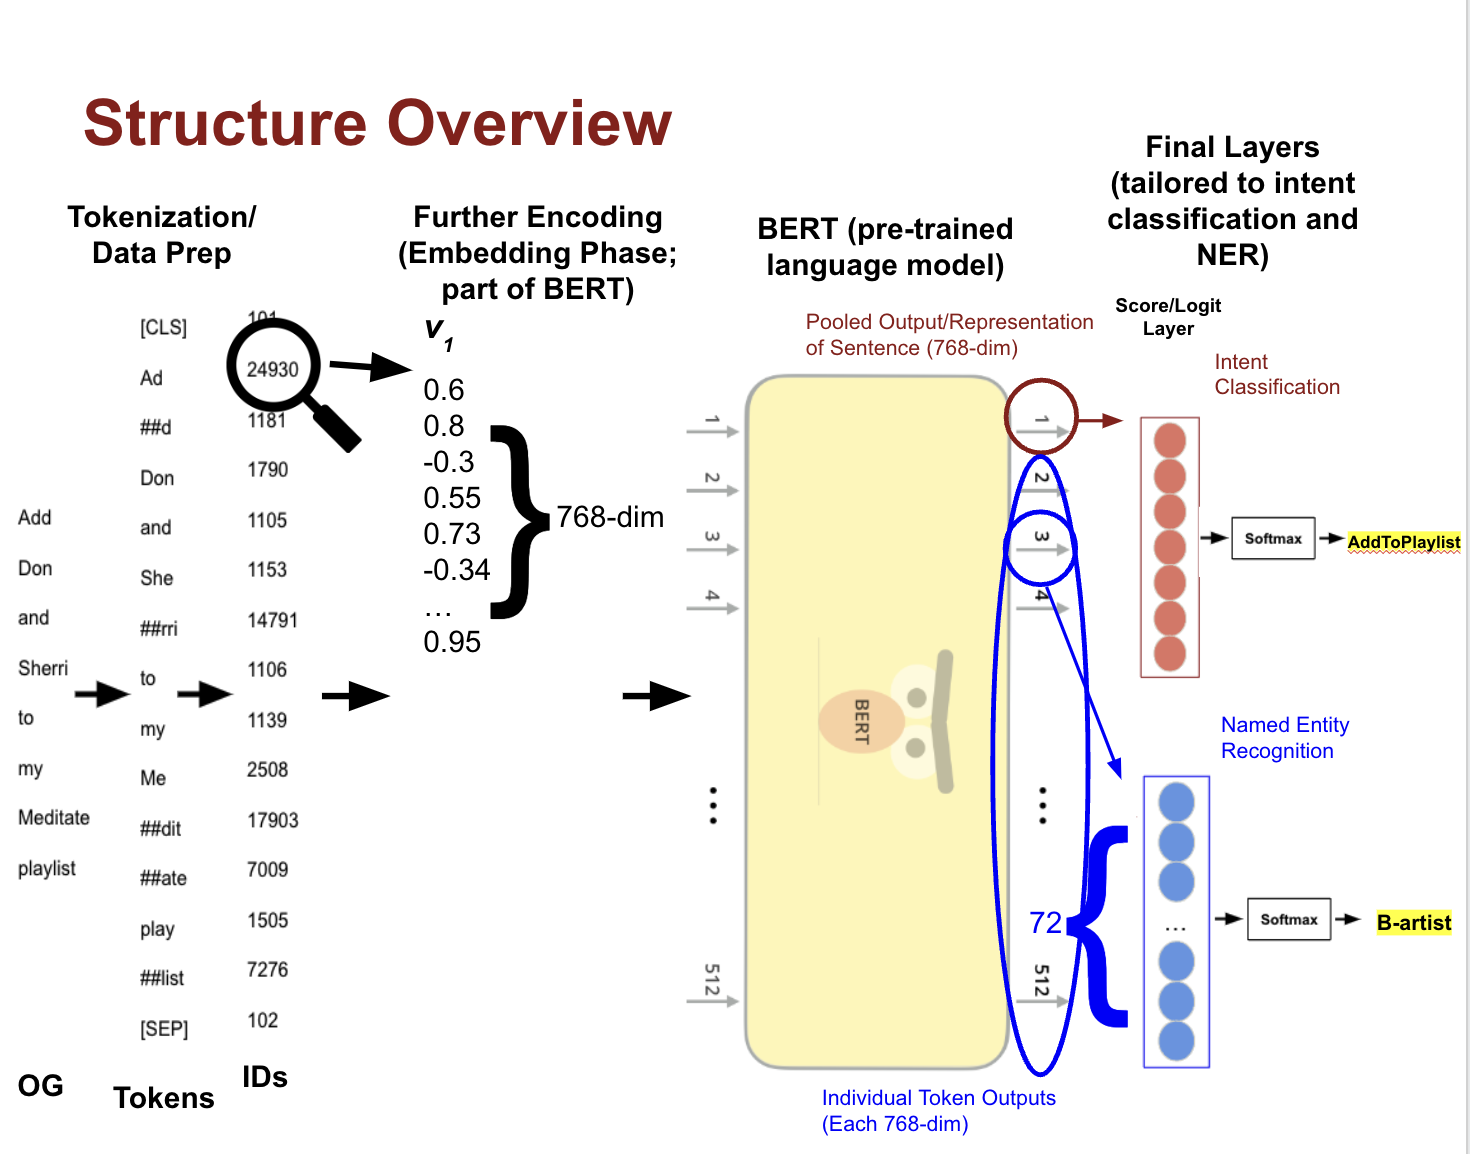